In [1]:
import csv
import numpy as np
import Loader
import Transformer
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

In [2]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

#print(labelsTrain)
#print(compoundsTrain)
#print(smilesTrain)
#print(activitiesTrain)

#for i in range(len(labelsTrain)):
#    print(labelsTrain[i] + ": ", compoundDataTrain[0,i])

# def toClassification(y): # The resulting array will contain values of -1 if it is below 4.5 and 1 if it is above
#     y = np.array(y)
#     classification = (y.astype(float)>4).astype(int)
#     return classification * 2 - 1

# def normalizeData(train,test,validate):
#     for i in range(np.shape(train)[1]):
#         std = np.std(train[:,i])
#         mean = np.mean(train[:,i])
#         if(std == 0):
#             std = 1
#         train[:,i] = (train[:,i] - mean) / std
#         test[:,i] = (test[:,i] - mean) / std
#         validate[:,i] = (validate[:,i] - mean) / std
#     return train, test, validate

# def normalize_2d(matrix):
#     norm = np.linalg.norm(matrix,np.inf)
#     matrix = matrix/norm  # normalized matrix
#     return matrix

# normalizeData(compoundDataTrain, compoundDataTest, compoundDataValidate)

# print(len(compoundsTrain), len(compoundsTest), len(compoundsValidate))

In [3]:
labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,4,4,3,3,3,3])

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)



bcut2d retention: [0.99364773]
	total: 99.3647727341231%
chi retention: [0.9541968]
	total: 95.41967968597893%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179]
	total: 73.743047918213%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840063%
slogp retention: [0.44620276 0.22134465 0.15753302]
	total: 82.50804204396218%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306429%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.84064669216791%
fr retention: [0.32153498 0.12578177 0.09944384]
	total: 54.67605936051172%


In [4]:
classify = Transformer.toClassification(activitiesTrain)

In [17]:
classTrain = Transformer.toClassification(activitiesTrain)
classVal = Transformer.toClassification(activitiesValidate)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
l1Reg = 0.001

model = Sequential()
model.add(Dense(200, input_dim=np.shape(trainData)[1], activation='softmax', kernel_regularizer = keras.regularizers.L2(l1Reg)))
model.add(Dense(150, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model.add(Dense(75, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model.fit(trainData, Transformer.toClassification(activitiesTrain), 
                    validation_data = (valData, classVal), epochs=1600, batch_size=4)

Epoch 1/1600
680/680 [==============================] - 1s 1ms/step - loss: 1.2877 - accuracy: 0.2205 - val_loss: 0.6534 - val_accuracy: 0.4029
Epoch 2/1600
680/680 [==============================] - 1s 1ms/step - loss: 0.5906 - accuracy: 0.4520 - val_loss: 0.5538 - val_accuracy: 0.4500
Epoch 3/1600
680/680 [==============================] - 1s 927us/step - loss: 0.5214 - accuracy: 0.4833 - val_loss: 0.5281 - val_accuracy: 0.4324
Epoch 4/1600
680/680 [==============================] - 1s 905us/step - loss: 0.4808 - accuracy: 0.4914 - val_loss: 0.5160 - val_accuracy: 0.4647
Epoch 5/1600
680/680 [==============================] - 1s 938us/step - loss: 0.4544 - accuracy: 0.5009 - val_loss: 0.4712 - val_accuracy: 0.4765
Epoch 6/1600
680/680 [==============================] - 1s 908us/step - loss: 0.4377 - accuracy: 0.5024 - val_loss: 0.4759 - val_accuracy: 0.4676
Epoch 7/1600
680/680 [==============================] - 1s 1ms/step - loss: 0.4203 - accuracy: 0.5086 - val_loss: 0.4479 - val_a

Epoch 57/1600
680/680 [==============================] - 1s 919us/step - loss: 0.2450 - accuracy: 0.5731 - val_loss: 0.3980 - val_accuracy: 0.5559
Epoch 58/1600
680/680 [==============================] - 1s 886us/step - loss: 0.2405 - accuracy: 0.5672 - val_loss: 0.3835 - val_accuracy: 0.5559
Epoch 59/1600
680/680 [==============================] - 1s 888us/step - loss: 0.2523 - accuracy: 0.5697 - val_loss: 0.3894 - val_accuracy: 0.5353
Epoch 60/1600
680/680 [==============================] - 1s 1ms/step - loss: 0.2396 - accuracy: 0.5716 - val_loss: 0.3919 - val_accuracy: 0.5353
Epoch 61/1600
680/680 [==============================] - 1s 1ms/step - loss: 0.2439 - accuracy: 0.5709 - val_loss: 0.3919 - val_accuracy: 0.5324
Epoch 62/1600
680/680 [==============================] - 1s 1ms/step - loss: 0.2408 - accuracy: 0.5701 - val_loss: 0.3771 - val_accuracy: 0.5441
Epoch 63/1600
680/680 [==============================] - 1s 971us/step - loss: 0.2315 - accuracy: 0.5731 - val_loss: 0.3942 

Epoch 113/1600
680/680 [==============================] - 1s 868us/step - loss: 0.2045 - accuracy: 0.5863 - val_loss: 0.3872 - val_accuracy: 0.5471
Epoch 114/1600
680/680 [==============================] - 1s 930us/step - loss: 0.2097 - accuracy: 0.5863 - val_loss: 0.3985 - val_accuracy: 0.5382
Epoch 115/1600
680/680 [==============================] - 1s 898us/step - loss: 0.2003 - accuracy: 0.5867 - val_loss: 0.3902 - val_accuracy: 0.5412
Epoch 116/1600
680/680 [==============================] - 1s 930us/step - loss: 0.1988 - accuracy: 0.5874 - val_loss: 0.3910 - val_accuracy: 0.5647
Epoch 117/1600
680/680 [==============================] - 1s 944us/step - loss: 0.1955 - accuracy: 0.5904 - val_loss: 0.4120 - val_accuracy: 0.5382
Epoch 118/1600
680/680 [==============================] - 1s 882us/step - loss: 0.2250 - accuracy: 0.5830 - val_loss: 0.4140 - val_accuracy: 0.5529
Epoch 119/1600
680/680 [==============================] - 1s 891us/step - loss: 0.2115 - accuracy: 0.5834 - val_

680/680 [==============================] - 1s 893us/step - loss: 0.1918 - accuracy: 0.5955 - val_loss: 0.3575 - val_accuracy: 0.5647
Epoch 224/1600
680/680 [==============================] - 1s 894us/step - loss: 0.1986 - accuracy: 0.5889 - val_loss: 0.4055 - val_accuracy: 0.5382
Epoch 225/1600
680/680 [==============================] - 1s 936us/step - loss: 0.1862 - accuracy: 0.5918 - val_loss: 0.3966 - val_accuracy: 0.5412
Epoch 226/1600
680/680 [==============================] - 1s 879us/step - loss: 0.2007 - accuracy: 0.5889 - val_loss: 0.4059 - val_accuracy: 0.5441
Epoch 227/1600
680/680 [==============================] - 1s 880us/step - loss: 0.1900 - accuracy: 0.5922 - val_loss: 0.3566 - val_accuracy: 0.5588
Epoch 228/1600
680/680 [==============================] - 1s 901us/step - loss: 0.1778 - accuracy: 0.5966 - val_loss: 0.3464 - val_accuracy: 0.5588
Epoch 229/1600
680/680 [==============================] - 1s 882us/step - loss: 0.1970 - accuracy: 0.5918 - val_loss: 0.4444 - 

680/680 [==============================] - 1s 878us/step - loss: 0.1706 - accuracy: 0.5962 - val_loss: 0.3606 - val_accuracy: 0.5471
Epoch 334/1600
680/680 [==============================] - 1s 898us/step - loss: 0.1797 - accuracy: 0.5959 - val_loss: 0.4249 - val_accuracy: 0.5324
Epoch 335/1600
680/680 [==============================] - 1s 894us/step - loss: 0.2065 - accuracy: 0.5904 - val_loss: 0.3632 - val_accuracy: 0.5529
Epoch 336/1600
680/680 [==============================] - 1s 896us/step - loss: 0.1858 - accuracy: 0.5918 - val_loss: 0.3783 - val_accuracy: 0.5441
Epoch 337/1600
680/680 [==============================] - 1s 932us/step - loss: 0.1811 - accuracy: 0.5948 - val_loss: 0.4058 - val_accuracy: 0.5588
Epoch 338/1600
680/680 [==============================] - 1s 927us/step - loss: 0.1921 - accuracy: 0.5915 - val_loss: 0.3495 - val_accuracy: 0.5588
Epoch 339/1600
680/680 [==============================] - 1s 881us/step - loss: 0.1772 - accuracy: 0.5937 - val_loss: 0.4115 - 

680/680 [==============================] - 1s 864us/step - loss: 0.1982 - accuracy: 0.5948 - val_loss: 0.3804 - val_accuracy: 0.5529
Epoch 444/1600
680/680 [==============================] - 1s 899us/step - loss: 0.1785 - accuracy: 0.5962 - val_loss: 0.3828 - val_accuracy: 0.5559
Epoch 445/1600
680/680 [==============================] - 1s 883us/step - loss: 0.1900 - accuracy: 0.5940 - val_loss: 0.3946 - val_accuracy: 0.5382
Epoch 446/1600
680/680 [==============================] - 1s 881us/step - loss: 0.1851 - accuracy: 0.5940 - val_loss: 0.3982 - val_accuracy: 0.5441
Epoch 447/1600
680/680 [==============================] - 1s 890us/step - loss: 0.1775 - accuracy: 0.5948 - val_loss: 0.4004 - val_accuracy: 0.5471
Epoch 448/1600
680/680 [==============================] - 1s 890us/step - loss: 0.1812 - accuracy: 0.5966 - val_loss: 0.3846 - val_accuracy: 0.5529
Epoch 449/1600
680/680 [==============================] - 1s 889us/step - loss: 0.1873 - accuracy: 0.5937 - val_loss: 0.4189 - 

680/680 [==============================] - 1s 925us/step - loss: 0.1773 - accuracy: 0.5966 - val_loss: 0.3940 - val_accuracy: 0.5441
Epoch 554/1600
680/680 [==============================] - 1s 876us/step - loss: 0.1708 - accuracy: 0.5985 - val_loss: 0.3792 - val_accuracy: 0.5500
Epoch 555/1600
680/680 [==============================] - 1s 904us/step - loss: 0.1842 - accuracy: 0.5959 - val_loss: 0.4092 - val_accuracy: 0.5412
Epoch 556/1600
680/680 [==============================] - 1s 894us/step - loss: 0.1840 - accuracy: 0.5929 - val_loss: 0.3899 - val_accuracy: 0.5559
Epoch 557/1600
680/680 [==============================] - 1s 870us/step - loss: 0.1823 - accuracy: 0.5922 - val_loss: 0.4387 - val_accuracy: 0.5471
Epoch 558/1600
680/680 [==============================] - 1s 886us/step - loss: 0.1762 - accuracy: 0.5959 - val_loss: 0.4443 - val_accuracy: 0.5441
Epoch 559/1600
680/680 [==============================] - 1s 885us/step - loss: 0.1873 - accuracy: 0.5937 - val_loss: 0.3941 - 

680/680 [==============================] - 1s 893us/step - loss: 0.1801 - accuracy: 0.5981 - val_loss: 0.4129 - val_accuracy: 0.5382
Epoch 664/1600
680/680 [==============================] - 1s 909us/step - loss: 0.1958 - accuracy: 0.5900 - val_loss: 0.4253 - val_accuracy: 0.5353
Epoch 665/1600
680/680 [==============================] - 1s 914us/step - loss: 0.1740 - accuracy: 0.5966 - val_loss: 0.4477 - val_accuracy: 0.5353
Epoch 666/1600
680/680 [==============================] - 1s 933us/step - loss: 0.1941 - accuracy: 0.5922 - val_loss: 0.4137 - val_accuracy: 0.5441
Epoch 667/1600
680/680 [==============================] - 1s 915us/step - loss: 0.1821 - accuracy: 0.5940 - val_loss: 0.3914 - val_accuracy: 0.5559
Epoch 668/1600
680/680 [==============================] - 1s 926us/step - loss: 0.1787 - accuracy: 0.5966 - val_loss: 0.4045 - val_accuracy: 0.5559
Epoch 669/1600
680/680 [==============================] - 1s 928us/step - loss: 0.1808 - accuracy: 0.5940 - val_loss: 0.4017 - 

680/680 [==============================] - 1s 924us/step - loss: 0.1893 - accuracy: 0.5933 - val_loss: 0.4036 - val_accuracy: 0.5529
Epoch 774/1600
680/680 [==============================] - 1s 918us/step - loss: 0.1668 - accuracy: 0.5974 - val_loss: 0.4447 - val_accuracy: 0.5441
Epoch 775/1600
680/680 [==============================] - 1s 921us/step - loss: 0.2049 - accuracy: 0.5922 - val_loss: 0.4371 - val_accuracy: 0.5353
Epoch 776/1600
680/680 [==============================] - 1s 925us/step - loss: 0.1838 - accuracy: 0.5937 - val_loss: 0.4229 - val_accuracy: 0.5441
Epoch 777/1600
680/680 [==============================] - 1s 918us/step - loss: 0.1782 - accuracy: 0.5951 - val_loss: 0.4130 - val_accuracy: 0.5529
Epoch 778/1600
680/680 [==============================] - 1s 930us/step - loss: 0.1748 - accuracy: 0.5933 - val_loss: 0.4156 - val_accuracy: 0.5412
Epoch 779/1600
680/680 [==============================] - 1s 910us/step - loss: 0.1856 - accuracy: 0.5948 - val_loss: 0.4259 - 

680/680 [==============================] - 1s 914us/step - loss: 0.1699 - accuracy: 0.5985 - val_loss: 0.4276 - val_accuracy: 0.5441
Epoch 884/1600
680/680 [==============================] - 1s 924us/step - loss: 0.1847 - accuracy: 0.5959 - val_loss: 0.4396 - val_accuracy: 0.5412
Epoch 885/1600
680/680 [==============================] - 1s 889us/step - loss: 0.1904 - accuracy: 0.5951 - val_loss: 0.4208 - val_accuracy: 0.5618
Epoch 886/1600
680/680 [==============================] - 1s 883us/step - loss: 0.1760 - accuracy: 0.5959 - val_loss: 0.4379 - val_accuracy: 0.5353
Epoch 887/1600
680/680 [==============================] - 1s 886us/step - loss: 0.1706 - accuracy: 0.5966 - val_loss: 0.4485 - val_accuracy: 0.5441
Epoch 888/1600
680/680 [==============================] - 1s 878us/step - loss: 0.1866 - accuracy: 0.5922 - val_loss: 0.4423 - val_accuracy: 0.5559
Epoch 889/1600
680/680 [==============================] - 1s 897us/step - loss: 0.1812 - accuracy: 0.5940 - val_loss: 0.4433 - 

680/680 [==============================] - 1s 879us/step - loss: 0.1816 - accuracy: 0.5948 - val_loss: 0.4065 - val_accuracy: 0.5559
Epoch 994/1600
680/680 [==============================] - 1s 877us/step - loss: 0.1984 - accuracy: 0.5904 - val_loss: 0.4340 - val_accuracy: 0.5441
Epoch 995/1600
680/680 [==============================] - 1s 887us/step - loss: 0.1765 - accuracy: 0.5951 - val_loss: 0.4116 - val_accuracy: 0.5441
Epoch 996/1600
680/680 [==============================] - 1s 877us/step - loss: 0.1885 - accuracy: 0.5933 - val_loss: 0.4698 - val_accuracy: 0.5206
Epoch 997/1600
680/680 [==============================] - 1s 878us/step - loss: 0.1729 - accuracy: 0.5977 - val_loss: 0.4226 - val_accuracy: 0.5471
Epoch 998/1600
680/680 [==============================] - 1s 879us/step - loss: 0.1679 - accuracy: 0.5977 - val_loss: 0.4201 - val_accuracy: 0.5441
Epoch 999/1600
680/680 [==============================] - 1s 880us/step - loss: 0.1815 - accuracy: 0.5948 - val_loss: 0.4013 - 

680/680 [==============================] - 1s 886us/step - loss: 0.1896 - accuracy: 0.5933 - val_loss: 0.4405 - val_accuracy: 0.5382
Epoch 1104/1600
680/680 [==============================] - 1s 880us/step - loss: 0.1705 - accuracy: 0.5955 - val_loss: 0.3942 - val_accuracy: 0.5559
Epoch 1105/1600
680/680 [==============================] - 1s 878us/step - loss: 0.1686 - accuracy: 0.5977 - val_loss: 0.4290 - val_accuracy: 0.5471
Epoch 1106/1600
680/680 [==============================] - 1s 885us/step - loss: 0.1731 - accuracy: 0.5988 - val_loss: 0.4368 - val_accuracy: 0.5441
Epoch 1107/1600
680/680 [==============================] - 1s 886us/step - loss: 0.1669 - accuracy: 0.5970 - val_loss: 0.4490 - val_accuracy: 0.5353
Epoch 1108/1600
680/680 [==============================] - 1s 882us/step - loss: 0.1791 - accuracy: 0.5977 - val_loss: 0.4146 - val_accuracy: 0.5529
Epoch 1109/1600
680/680 [==============================] - 1s 888us/step - loss: 0.2028 - accuracy: 0.5922 - val_loss: 0.4

680/680 [==============================] - 1s 877us/step - loss: 0.1824 - accuracy: 0.5962 - val_loss: 0.4718 - val_accuracy: 0.5353
Epoch 1159/1600
680/680 [==============================] - 1s 922us/step - loss: 0.1725 - accuracy: 0.5940 - val_loss: 0.4224 - val_accuracy: 0.5500
Epoch 1160/1600
680/680 [==============================] - 1s 917us/step - loss: 0.1815 - accuracy: 0.5944 - val_loss: 0.4624 - val_accuracy: 0.5265
Epoch 1161/1600
680/680 [==============================] - 1s 943us/step - loss: 0.1875 - accuracy: 0.5966 - val_loss: 0.4449 - val_accuracy: 0.5382
Epoch 1162/1600
680/680 [==============================] - 1s 912us/step - loss: 0.1667 - accuracy: 0.5988 - val_loss: 0.4340 - val_accuracy: 0.5353
Epoch 1163/1600
680/680 [==============================] - 1s 926us/step - loss: 0.1626 - accuracy: 0.5988 - val_loss: 0.4429 - val_accuracy: 0.5441
Epoch 1164/1600
680/680 [==============================] - 1s 929us/step - loss: 0.1750 - accuracy: 0.5974 - val_loss: 0.4

680/680 [==============================] - 1s 921us/step - loss: 0.1730 - accuracy: 0.5974 - val_loss: 0.4547 - val_accuracy: 0.5324
Epoch 1214/1600
680/680 [==============================] - 1s 919us/step - loss: 0.1762 - accuracy: 0.5948 - val_loss: 0.4301 - val_accuracy: 0.5471
Epoch 1215/1600
680/680 [==============================] - 1s 925us/step - loss: 0.1711 - accuracy: 0.5988 - val_loss: 0.4514 - val_accuracy: 0.5412
Epoch 1216/1600
680/680 [==============================] - 1s 925us/step - loss: 0.1821 - accuracy: 0.5937 - val_loss: 0.4296 - val_accuracy: 0.5324
Epoch 1217/1600
680/680 [==============================] - 1s 913us/step - loss: 0.1666 - accuracy: 0.5962 - val_loss: 0.4323 - val_accuracy: 0.5412
Epoch 1218/1600
680/680 [==============================] - 1s 919us/step - loss: 0.1794 - accuracy: 0.5959 - val_loss: 0.4317 - val_accuracy: 0.5471
Epoch 1219/1600
680/680 [==============================] - 1s 924us/step - loss: 0.1761 - accuracy: 0.5977 - val_loss: 0.4

680/680 [==============================] - 1s 932us/step - loss: 0.1878 - accuracy: 0.5966 - val_loss: 0.4282 - val_accuracy: 0.5382
Epoch 1269/1600
680/680 [==============================] - 1s 893us/step - loss: 0.1566 - accuracy: 0.6010 - val_loss: 0.4352 - val_accuracy: 0.5382
Epoch 1270/1600
680/680 [==============================] - 1s 927us/step - loss: 0.1813 - accuracy: 0.5933 - val_loss: 0.4754 - val_accuracy: 0.5294
Epoch 1271/1600
680/680 [==============================] - 1s 907us/step - loss: 0.1764 - accuracy: 0.5962 - val_loss: 0.4575 - val_accuracy: 0.5265
Epoch 1272/1600
680/680 [==============================] - 1s 973us/step - loss: 0.1797 - accuracy: 0.5929 - val_loss: 0.4489 - val_accuracy: 0.5412
Epoch 1273/1600
680/680 [==============================] - 1s 980us/step - loss: 0.1652 - accuracy: 0.5988 - val_loss: 0.4232 - val_accuracy: 0.5412
Epoch 1274/1600
680/680 [==============================] - 1s 911us/step - loss: 0.1907 - accuracy: 0.5904 - val_loss: 0.5

680/680 [==============================] - 1s 899us/step - loss: 0.1897 - accuracy: 0.5940 - val_loss: 0.4457 - val_accuracy: 0.5441
Epoch 1324/1600
680/680 [==============================] - 1s 870us/step - loss: 0.1686 - accuracy: 0.5962 - val_loss: 0.4435 - val_accuracy: 0.5353
Epoch 1325/1600
680/680 [==============================] - 1s 891us/step - loss: 0.1800 - accuracy: 0.5970 - val_loss: 0.4867 - val_accuracy: 0.5235
Epoch 1326/1600
680/680 [==============================] - 1s 894us/step - loss: 0.1758 - accuracy: 0.5940 - val_loss: 0.4294 - val_accuracy: 0.5412
Epoch 1327/1600
680/680 [==============================] - 1s 919us/step - loss: 0.1702 - accuracy: 0.5985 - val_loss: 0.4677 - val_accuracy: 0.5412
Epoch 1328/1600
680/680 [==============================] - 1s 919us/step - loss: 0.1746 - accuracy: 0.5944 - val_loss: 0.4345 - val_accuracy: 0.5471
Epoch 1329/1600
680/680 [==============================] - 1s 922us/step - loss: 0.1773 - accuracy: 0.5951 - val_loss: 0.4

680/680 [==============================] - 1s 927us/step - loss: 0.1713 - accuracy: 0.5962 - val_loss: 0.4684 - val_accuracy: 0.5471
Epoch 1379/1600
680/680 [==============================] - 1s 922us/step - loss: 0.1793 - accuracy: 0.5951 - val_loss: 0.4878 - val_accuracy: 0.5294
Epoch 1380/1600
680/680 [==============================] - 1s 929us/step - loss: 0.1764 - accuracy: 0.5948 - val_loss: 0.4511 - val_accuracy: 0.5529
Epoch 1381/1600
680/680 [==============================] - 1s 922us/step - loss: 0.1718 - accuracy: 0.5977 - val_loss: 0.4760 - val_accuracy: 0.5294
Epoch 1382/1600
680/680 [==============================] - 1s 973us/step - loss: 0.1669 - accuracy: 0.5959 - val_loss: 0.4865 - val_accuracy: 0.5588
Epoch 1383/1600
680/680 [==============================] - 1s 949us/step - loss: 0.1810 - accuracy: 0.5926 - val_loss: 0.4529 - val_accuracy: 0.5324
Epoch 1384/1600
680/680 [==============================] - 1s 920us/step - loss: 0.1753 - accuracy: 0.5951 - val_loss: 0.4

680/680 [==============================] - 1s 887us/step - loss: 0.1725 - accuracy: 0.5962 - val_loss: 0.4909 - val_accuracy: 0.5353
Epoch 1434/1600
680/680 [==============================] - 1s 880us/step - loss: 0.1642 - accuracy: 0.5985 - val_loss: 0.4842 - val_accuracy: 0.5235
Epoch 1435/1600
680/680 [==============================] - 1s 887us/step - loss: 0.1716 - accuracy: 0.5951 - val_loss: 0.4911 - val_accuracy: 0.5206
Epoch 1436/1600
680/680 [==============================] - 1s 871us/step - loss: 0.1699 - accuracy: 0.5955 - val_loss: 0.4655 - val_accuracy: 0.5324
Epoch 1437/1600
680/680 [==============================] - 1s 929us/step - loss: 0.1766 - accuracy: 0.5959 - val_loss: 0.4634 - val_accuracy: 0.5441
Epoch 1438/1600
680/680 [==============================] - 1s 916us/step - loss: 0.1680 - accuracy: 0.5959 - val_loss: 0.4473 - val_accuracy: 0.5441
Epoch 1439/1600
680/680 [==============================] - 1s 931us/step - loss: 0.1654 - accuracy: 0.5985 - val_loss: 0.4

680/680 [==============================] - 1s 921us/step - loss: 0.1609 - accuracy: 0.5974 - val_loss: 0.4727 - val_accuracy: 0.5471
Epoch 1489/1600
680/680 [==============================] - 1s 885us/step - loss: 0.1734 - accuracy: 0.5962 - val_loss: 0.4273 - val_accuracy: 0.5353
Epoch 1490/1600
680/680 [==============================] - 1s 888us/step - loss: 0.1733 - accuracy: 0.5974 - val_loss: 0.4254 - val_accuracy: 0.5382
Epoch 1491/1600
680/680 [==============================] - 1s 899us/step - loss: 0.1725 - accuracy: 0.5948 - val_loss: 0.5047 - val_accuracy: 0.5441
Epoch 1492/1600
680/680 [==============================] - 1s 908us/step - loss: 0.1877 - accuracy: 0.5915 - val_loss: 0.4504 - val_accuracy: 0.5412
Epoch 1493/1600
680/680 [==============================] - 1s 885us/step - loss: 0.1713 - accuracy: 0.5955 - val_loss: 0.4856 - val_accuracy: 0.5441
Epoch 1494/1600
680/680 [==============================] - 1s 877us/step - loss: 0.1814 - accuracy: 0.5940 - val_loss: 0.4

680/680 [==============================] - 1s 883us/step - loss: 0.1702 - accuracy: 0.5974 - val_loss: 0.4817 - val_accuracy: 0.5324
Epoch 1544/1600
680/680 [==============================] - 1s 896us/step - loss: 0.1787 - accuracy: 0.5948 - val_loss: 0.5056 - val_accuracy: 0.5206
Epoch 1545/1600
680/680 [==============================] - 1s 882us/step - loss: 0.1720 - accuracy: 0.5974 - val_loss: 0.4501 - val_accuracy: 0.5294
Epoch 1546/1600
680/680 [==============================] - 1s 882us/step - loss: 0.1775 - accuracy: 0.5948 - val_loss: 0.4601 - val_accuracy: 0.5500
Epoch 1547/1600
680/680 [==============================] - 1s 877us/step - loss: 0.1661 - accuracy: 0.5970 - val_loss: 0.4732 - val_accuracy: 0.5441
Epoch 1548/1600
680/680 [==============================] - 1s 883us/step - loss: 0.1720 - accuracy: 0.5944 - val_loss: 0.4667 - val_accuracy: 0.5382
Epoch 1549/1600
680/680 [==============================] - 1s 878us/step - loss: 0.1755 - accuracy: 0.5948 - val_loss: 0.4

680/680 [==============================] - 1s 935us/step - loss: 0.1736 - accuracy: 0.5966 - val_loss: 0.4545 - val_accuracy: 0.5441
Epoch 1599/1600
680/680 [==============================] - 1s 840us/step - loss: 0.1876 - accuracy: 0.5937 - val_loss: 0.4849 - val_accuracy: 0.5324
Epoch 1600/1600
680/680 [==============================] - 1s 871us/step - loss: 0.1627 - accuracy: 0.5988 - val_loss: 0.4455 - val_accuracy: 0.5471


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


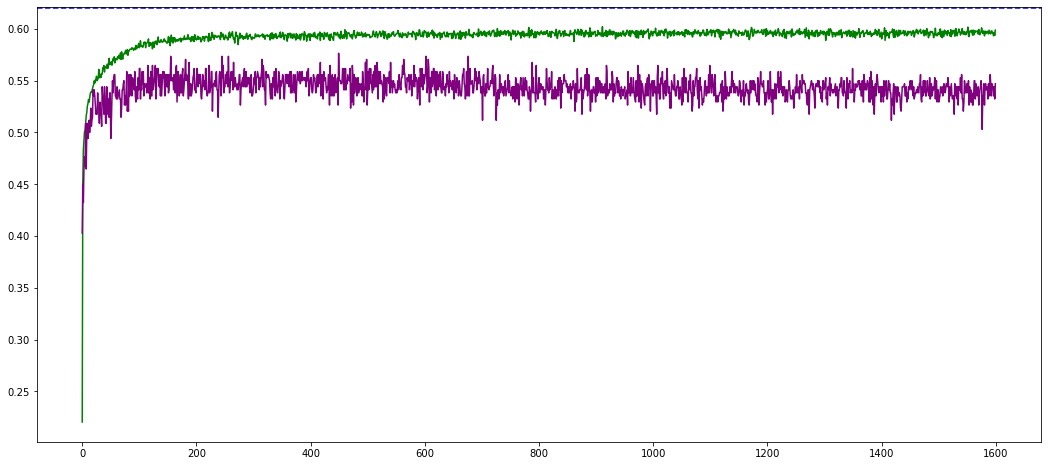

In [18]:
import matplotlib.pyplot as plt

print(history.history.keys())

classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)


fig, ax = plt.subplots(figsize=(18,8))

ax.plot(history.history["accuracy"], color="green")
ax.plot(history.history["val_accuracy"], color="purple")
ax.axhline(constantGuess, color="blue", linestyle="dashed")

In [6]:
classTrain = Transformer.toClassification(activitiesTrain)
classVal = Transformer.toClassification(activitiesValidate)

model = Sequential()
model.add(Dense(200, input_dim=np.shape(trainData)[1], activation='softmax', kernel_regularizer = keras.regularizers.L2(0.001)))
model.add(Dense(150, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model.add(Dense(50, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model.fit(trainData, Transformer.toClassification(activitiesTrain), 
                    validation_data = (valData, classVal), epochs=1600, batch_size=4)

Epoch 1/1600
680/680 [==============================] - 1s 1ms/step - loss: 1.0216 - accuracy: 0.2805 - val_loss: 0.5836 - val_accuracy: 0.4206
Epoch 2/1600
680/680 [==============================] - 1s 860us/step - loss: 0.5192 - accuracy: 0.4682 - val_loss: 0.4951 - val_accuracy: 0.5118
Epoch 3/1600
680/680 [==============================] - 1s 824us/step - loss: 0.4457 - accuracy: 0.5013 - val_loss: 0.4601 - val_accuracy: 0.5000
Epoch 4/1600
680/680 [==============================] - 1s 825us/step - loss: 0.4104 - accuracy: 0.5105 - val_loss: 0.4457 - val_accuracy: 0.4971
Epoch 5/1600
680/680 [==============================] - 1s 845us/step - loss: 0.3924 - accuracy: 0.5208 - val_loss: 0.4380 - val_accuracy: 0.5059
Epoch 6/1600
680/680 [==============================] - 1s 818us/step - loss: 0.3745 - accuracy: 0.5212 - val_loss: 0.4542 - val_accuracy: 0.4853
Epoch 7/1600
680/680 [==============================] - 1s 868us/step - loss: 0.3626 - accuracy: 0.5252 - val_loss: 0.4380 - v

Epoch 57/1600
680/680 [==============================] - 1s 1ms/step - loss: 0.1963 - accuracy: 0.5859 - val_loss: 0.4472 - val_accuracy: 0.5588
Epoch 58/1600
680/680 [==============================] - 1s 954us/step - loss: 0.1968 - accuracy: 0.5852 - val_loss: 0.4266 - val_accuracy: 0.5618
Epoch 59/1600
680/680 [==============================] - 1s 956us/step - loss: 0.1830 - accuracy: 0.5900 - val_loss: 0.4394 - val_accuracy: 0.5618
Epoch 60/1600
680/680 [==============================] - 1s 853us/step - loss: 0.1939 - accuracy: 0.5878 - val_loss: 0.4747 - val_accuracy: 0.5588
Epoch 61/1600
680/680 [==============================] - 1s 834us/step - loss: 0.1887 - accuracy: 0.5878 - val_loss: 0.4374 - val_accuracy: 0.5500
Epoch 62/1600
680/680 [==============================] - 1s 827us/step - loss: 0.1870 - accuracy: 0.5904 - val_loss: 0.4497 - val_accuracy: 0.5588
Epoch 63/1600
680/680 [==============================] - 1s 824us/step - loss: 0.1934 - accuracy: 0.5915 - val_loss: 0.4

680/680 [==============================] - 1s 759us/step - loss: 0.1551 - accuracy: 0.5988 - val_loss: 0.4319 - val_accuracy: 0.5618
Epoch 113/1600
680/680 [==============================] - 1s 758us/step - loss: 0.1620 - accuracy: 0.5981 - val_loss: 0.4454 - val_accuracy: 0.5588
Epoch 114/1600
680/680 [==============================] - 1s 764us/step - loss: 0.1766 - accuracy: 0.5922 - val_loss: 0.4142 - val_accuracy: 0.5559
Epoch 115/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1699 - accuracy: 0.5937 - val_loss: 0.4236 - val_accuracy: 0.5559
Epoch 116/1600
680/680 [==============================] - 1s 757us/step - loss: 0.1603 - accuracy: 0.5988 - val_loss: 0.4354 - val_accuracy: 0.5588
Epoch 117/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1556 - accuracy: 0.6003 - val_loss: 0.4146 - val_accuracy: 0.5559
Epoch 118/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1686 - accuracy: 0.5940 - val_loss: 0.4312 - 

680/680 [==============================] - 1s 749us/step - loss: 0.1677 - accuracy: 0.5962 - val_loss: 0.4339 - val_accuracy: 0.5441
Epoch 168/1600
680/680 [==============================] - 1s 743us/step - loss: 0.1590 - accuracy: 0.5977 - val_loss: 0.4204 - val_accuracy: 0.5588
Epoch 169/1600
680/680 [==============================] - 1s 832us/step - loss: 0.1579 - accuracy: 0.5970 - val_loss: 0.4658 - val_accuracy: 0.5559
Epoch 170/1600
680/680 [==============================] - 1s 826us/step - loss: 0.1580 - accuracy: 0.5992 - val_loss: 0.4415 - val_accuracy: 0.5676
Epoch 171/1600
680/680 [==============================] - 1s 738us/step - loss: 0.1594 - accuracy: 0.5977 - val_loss: 0.4379 - val_accuracy: 0.5529
Epoch 172/1600
680/680 [==============================] - 0s 669us/step - loss: 0.1743 - accuracy: 0.5926 - val_loss: 0.4349 - val_accuracy: 0.5588
Epoch 173/1600
680/680 [==============================] - 0s 722us/step - loss: 0.1588 - accuracy: 0.5981 - val_loss: 0.4297 - 

680/680 [==============================] - 1s 754us/step - loss: 0.1604 - accuracy: 0.5974 - val_loss: 0.4215 - val_accuracy: 0.5588
Epoch 223/1600
680/680 [==============================] - 1s 754us/step - loss: 0.1610 - accuracy: 0.5981 - val_loss: 0.4605 - val_accuracy: 0.5559
Epoch 224/1600
680/680 [==============================] - 1s 796us/step - loss: 0.1495 - accuracy: 0.5985 - val_loss: 0.5001 - val_accuracy: 0.5618
Epoch 225/1600
680/680 [==============================] - 1s 797us/step - loss: 0.1667 - accuracy: 0.5951 - val_loss: 0.4341 - val_accuracy: 0.5588
Epoch 226/1600
680/680 [==============================] - 1s 749us/step - loss: 0.1503 - accuracy: 0.6021 - val_loss: 0.4409 - val_accuracy: 0.5559
Epoch 227/1600
680/680 [==============================] - 1s 748us/step - loss: 0.1619 - accuracy: 0.6003 - val_loss: 0.4255 - val_accuracy: 0.5559
Epoch 228/1600
680/680 [==============================] - 1s 795us/step - loss: 0.1564 - accuracy: 0.6007 - val_loss: 0.4466 - 

680/680 [==============================] - 0s 714us/step - loss: 0.1526 - accuracy: 0.6018 - val_loss: 0.4660 - val_accuracy: 0.5588
Epoch 278/1600
680/680 [==============================] - 0s 716us/step - loss: 0.1585 - accuracy: 0.5988 - val_loss: 0.4777 - val_accuracy: 0.5500
Epoch 279/1600
680/680 [==============================] - 0s 715us/step - loss: 0.1698 - accuracy: 0.5981 - val_loss: 0.4201 - val_accuracy: 0.5588
Epoch 280/1600
680/680 [==============================] - 0s 710us/step - loss: 0.1489 - accuracy: 0.6003 - val_loss: 0.4413 - val_accuracy: 0.5618
Epoch 281/1600
680/680 [==============================] - 0s 714us/step - loss: 0.1598 - accuracy: 0.5999 - val_loss: 0.4934 - val_accuracy: 0.5559
Epoch 282/1600
680/680 [==============================] - 1s 755us/step - loss: 0.1612 - accuracy: 0.5981 - val_loss: 0.4824 - val_accuracy: 0.5588
Epoch 283/1600
680/680 [==============================] - 1s 758us/step - loss: 0.1669 - accuracy: 0.5962 - val_loss: 0.4566 - 

680/680 [==============================] - 0s 710us/step - loss: 0.1509 - accuracy: 0.6007 - val_loss: 0.4434 - val_accuracy: 0.5529
Epoch 333/1600
680/680 [==============================] - 0s 709us/step - loss: 0.1588 - accuracy: 0.5981 - val_loss: 0.4519 - val_accuracy: 0.5471
Epoch 334/1600
680/680 [==============================] - 0s 712us/step - loss: 0.1571 - accuracy: 0.6010 - val_loss: 0.4404 - val_accuracy: 0.5588
Epoch 335/1600
680/680 [==============================] - 0s 710us/step - loss: 0.1568 - accuracy: 0.5977 - val_loss: 0.4786 - val_accuracy: 0.5529
Epoch 336/1600
680/680 [==============================] - 1s 829us/step - loss: 0.1520 - accuracy: 0.6014 - val_loss: 0.4649 - val_accuracy: 0.5559
Epoch 337/1600
680/680 [==============================] - 1s 806us/step - loss: 0.1635 - accuracy: 0.5974 - val_loss: 0.4399 - val_accuracy: 0.5588
Epoch 338/1600
680/680 [==============================] - 1s 773us/step - loss: 0.1595 - accuracy: 0.5996 - val_loss: 0.4431 - 

680/680 [==============================] - 1s 750us/step - loss: 0.1517 - accuracy: 0.6003 - val_loss: 0.4474 - val_accuracy: 0.5618
Epoch 388/1600
680/680 [==============================] - 0s 703us/step - loss: 0.1644 - accuracy: 0.5955 - val_loss: 0.4369 - val_accuracy: 0.5676
Epoch 389/1600
680/680 [==============================] - 0s 714us/step - loss: 0.1509 - accuracy: 0.5999 - val_loss: 0.4313 - val_accuracy: 0.5529
Epoch 390/1600
680/680 [==============================] - 0s 711us/step - loss: 0.1586 - accuracy: 0.5974 - val_loss: 0.4449 - val_accuracy: 0.5588
Epoch 391/1600
680/680 [==============================] - 0s 708us/step - loss: 0.1662 - accuracy: 0.5981 - val_loss: 0.4592 - val_accuracy: 0.5588
Epoch 392/1600
680/680 [==============================] - 0s 711us/step - loss: 0.1721 - accuracy: 0.5970 - val_loss: 0.4622 - val_accuracy: 0.5529
Epoch 393/1600
680/680 [==============================] - 0s 713us/step - loss: 0.1442 - accuracy: 0.6021 - val_loss: 0.4565 - 

680/680 [==============================] - 1s 782us/step - loss: 0.1582 - accuracy: 0.6014 - val_loss: 0.4434 - val_accuracy: 0.5559
Epoch 443/1600
680/680 [==============================] - 1s 793us/step - loss: 0.1594 - accuracy: 0.5977 - val_loss: 0.4681 - val_accuracy: 0.5529
Epoch 444/1600
680/680 [==============================] - 1s 784us/step - loss: 0.1616 - accuracy: 0.5970 - val_loss: 0.4219 - val_accuracy: 0.5471
Epoch 445/1600
680/680 [==============================] - 1s 790us/step - loss: 0.1539 - accuracy: 0.5999 - val_loss: 0.4468 - val_accuracy: 0.5529
Epoch 446/1600
680/680 [==============================] - 0s 712us/step - loss: 0.1540 - accuracy: 0.6010 - val_loss: 0.4640 - val_accuracy: 0.5559
Epoch 447/1600
680/680 [==============================] - 1s 744us/step - loss: 0.1598 - accuracy: 0.5996 - val_loss: 0.4369 - val_accuracy: 0.5471
Epoch 448/1600
680/680 [==============================] - 1s 797us/step - loss: 0.1426 - accuracy: 0.6058 - val_loss: 0.4566 - 

680/680 [==============================] - 1s 749us/step - loss: 0.1475 - accuracy: 0.6025 - val_loss: 0.4295 - val_accuracy: 0.5618
Epoch 498/1600
680/680 [==============================] - 1s 743us/step - loss: 0.1393 - accuracy: 0.6036 - val_loss: 0.4512 - val_accuracy: 0.5529
Epoch 499/1600
680/680 [==============================] - 1s 752us/step - loss: 0.1561 - accuracy: 0.5992 - val_loss: 0.4293 - val_accuracy: 0.5618
Epoch 500/1600
680/680 [==============================] - 1s 793us/step - loss: 0.1701 - accuracy: 0.5970 - val_loss: 0.4637 - val_accuracy: 0.5529
Epoch 501/1600
680/680 [==============================] - 1s 791us/step - loss: 0.1719 - accuracy: 0.5962 - val_loss: 0.4390 - val_accuracy: 0.5559
Epoch 502/1600
680/680 [==============================] - 1s 747us/step - loss: 0.1472 - accuracy: 0.6003 - val_loss: 0.4422 - val_accuracy: 0.5618
Epoch 503/1600
680/680 [==============================] - 0s 731us/step - loss: 0.1677 - accuracy: 0.5970 - val_loss: 0.4406 - 

680/680 [==============================] - 0s 731us/step - loss: 0.1545 - accuracy: 0.6007 - val_loss: 0.4863 - val_accuracy: 0.5647
Epoch 553/1600
680/680 [==============================] - 0s 702us/step - loss: 0.1671 - accuracy: 0.5955 - val_loss: 0.4429 - val_accuracy: 0.5618
Epoch 554/1600
680/680 [==============================] - 0s 715us/step - loss: 0.1509 - accuracy: 0.6007 - val_loss: 0.5211 - val_accuracy: 0.5588
Epoch 555/1600
680/680 [==============================] - 1s 754us/step - loss: 0.1595 - accuracy: 0.5977 - val_loss: 0.4605 - val_accuracy: 0.5529
Epoch 556/1600
680/680 [==============================] - 0s 716us/step - loss: 0.1606 - accuracy: 0.5988 - val_loss: 0.4449 - val_accuracy: 0.5559
Epoch 557/1600
680/680 [==============================] - 1s 780us/step - loss: 0.1585 - accuracy: 0.5974 - val_loss: 0.4338 - val_accuracy: 0.5529
Epoch 558/1600
680/680 [==============================] - 0s 715us/step - loss: 0.1552 - accuracy: 0.5981 - val_loss: 0.4668 - 

680/680 [==============================] - 1s 748us/step - loss: 0.1578 - accuracy: 0.5981 - val_loss: 0.4477 - val_accuracy: 0.5471
Epoch 608/1600
680/680 [==============================] - 1s 743us/step - loss: 0.1526 - accuracy: 0.5996 - val_loss: 0.4722 - val_accuracy: 0.5529
Epoch 609/1600
680/680 [==============================] - 1s 746us/step - loss: 0.1504 - accuracy: 0.6007 - val_loss: 0.4837 - val_accuracy: 0.5412
Epoch 610/1600
680/680 [==============================] - 1s 750us/step - loss: 0.1575 - accuracy: 0.5981 - val_loss: 0.4465 - val_accuracy: 0.5500
Epoch 611/1600
680/680 [==============================] - 1s 787us/step - loss: 0.1454 - accuracy: 0.6014 - val_loss: 0.4633 - val_accuracy: 0.5588
Epoch 612/1600
680/680 [==============================] - 1s 793us/step - loss: 0.1557 - accuracy: 0.5977 - val_loss: 0.4376 - val_accuracy: 0.5618
Epoch 613/1600
680/680 [==============================] - 1s 786us/step - loss: 0.1442 - accuracy: 0.6021 - val_loss: 0.4731 - 

680/680 [==============================] - 1s 791us/step - loss: 0.1663 - accuracy: 0.5977 - val_loss: 0.4801 - val_accuracy: 0.5559
Epoch 663/1600
680/680 [==============================] - 1s 787us/step - loss: 0.1553 - accuracy: 0.5981 - val_loss: 0.4349 - val_accuracy: 0.5618
Epoch 664/1600
680/680 [==============================] - 1s 778us/step - loss: 0.1453 - accuracy: 0.6025 - val_loss: 0.4419 - val_accuracy: 0.5588
Epoch 665/1600
680/680 [==============================] - 1s 785us/step - loss: 0.1462 - accuracy: 0.6018 - val_loss: 0.4303 - val_accuracy: 0.5529
Epoch 666/1600
680/680 [==============================] - 1s 790us/step - loss: 0.1517 - accuracy: 0.6014 - val_loss: 0.4318 - val_accuracy: 0.5559
Epoch 667/1600
680/680 [==============================] - 1s 784us/step - loss: 0.1495 - accuracy: 0.6021 - val_loss: 0.4397 - val_accuracy: 0.5500
Epoch 668/1600
680/680 [==============================] - 1s 793us/step - loss: 0.1746 - accuracy: 0.5929 - val_loss: 0.4552 - 

680/680 [==============================] - 1s 749us/step - loss: 0.1506 - accuracy: 0.5992 - val_loss: 0.4685 - val_accuracy: 0.5588
Epoch 718/1600
680/680 [==============================] - 1s 750us/step - loss: 0.1561 - accuracy: 0.5992 - val_loss: 0.4790 - val_accuracy: 0.5618
Epoch 719/1600
680/680 [==============================] - 1s 745us/step - loss: 0.1497 - accuracy: 0.5996 - val_loss: 0.4723 - val_accuracy: 0.5559
Epoch 720/1600
680/680 [==============================] - 1s 750us/step - loss: 0.1583 - accuracy: 0.5992 - val_loss: 0.4198 - val_accuracy: 0.5500
Epoch 721/1600
680/680 [==============================] - 1s 757us/step - loss: 0.1454 - accuracy: 0.6007 - val_loss: 0.4625 - val_accuracy: 0.5559
Epoch 722/1600
680/680 [==============================] - 1s 749us/step - loss: 0.1505 - accuracy: 0.5992 - val_loss: 0.4721 - val_accuracy: 0.5471
Epoch 723/1600
680/680 [==============================] - 1s 749us/step - loss: 0.1431 - accuracy: 0.6025 - val_loss: 0.4308 - 

680/680 [==============================] - 1s 745us/step - loss: 0.1471 - accuracy: 0.6010 - val_loss: 0.4313 - val_accuracy: 0.5471
Epoch 773/1600
680/680 [==============================] - 0s 648us/step - loss: 0.1592 - accuracy: 0.5992 - val_loss: 0.4335 - val_accuracy: 0.5529
Epoch 774/1600
680/680 [==============================] - 0s 664us/step - loss: 0.1381 - accuracy: 0.6032 - val_loss: 0.4693 - val_accuracy: 0.5500
Epoch 775/1600
680/680 [==============================] - 0s 657us/step - loss: 0.1584 - accuracy: 0.5996 - val_loss: 0.4705 - val_accuracy: 0.5206
Epoch 776/1600
680/680 [==============================] - 0s 650us/step - loss: 0.1596 - accuracy: 0.5955 - val_loss: 0.4509 - val_accuracy: 0.5588
Epoch 777/1600
680/680 [==============================] - 0s 696us/step - loss: 0.1539 - accuracy: 0.5981 - val_loss: 0.4245 - val_accuracy: 0.5500
Epoch 778/1600
680/680 [==============================] - 0s 676us/step - loss: 0.1388 - accuracy: 0.6010 - val_loss: 0.4475 - 

680/680 [==============================] - 1s 764us/step - loss: 0.1611 - accuracy: 0.5999 - val_loss: 0.4442 - val_accuracy: 0.5588
Epoch 828/1600
680/680 [==============================] - 1s 748us/step - loss: 0.1546 - accuracy: 0.5981 - val_loss: 0.4431 - val_accuracy: 0.5588
Epoch 829/1600
680/680 [==============================] - 1s 745us/step - loss: 0.1450 - accuracy: 0.6021 - val_loss: 0.4512 - val_accuracy: 0.5500
Epoch 830/1600
680/680 [==============================] - 1s 741us/step - loss: 0.1551 - accuracy: 0.5999 - val_loss: 0.4627 - val_accuracy: 0.5588
Epoch 831/1600
680/680 [==============================] - 1s 736us/step - loss: 0.1580 - accuracy: 0.5992 - val_loss: 0.4383 - val_accuracy: 0.5588
Epoch 832/1600
680/680 [==============================] - 1s 735us/step - loss: 0.1535 - accuracy: 0.5996 - val_loss: 0.5004 - val_accuracy: 0.5706
Epoch 833/1600
680/680 [==============================] - 0s 671us/step - loss: 0.1564 - accuracy: 0.6010 - val_loss: 0.4291 - 

680/680 [==============================] - 1s 790us/step - loss: 0.1742 - accuracy: 0.5977 - val_loss: 0.4325 - val_accuracy: 0.5618
Epoch 883/1600
680/680 [==============================] - 1s 786us/step - loss: 0.1601 - accuracy: 0.5996 - val_loss: 0.4614 - val_accuracy: 0.5471
Epoch 884/1600
680/680 [==============================] - 1s 792us/step - loss: 0.1429 - accuracy: 0.6018 - val_loss: 0.4152 - val_accuracy: 0.5559
Epoch 885/1600
680/680 [==============================] - 1s 788us/step - loss: 0.1535 - accuracy: 0.6003 - val_loss: 0.4852 - val_accuracy: 0.5618
Epoch 886/1600
680/680 [==============================] - 1s 792us/step - loss: 0.1560 - accuracy: 0.6003 - val_loss: 0.4540 - val_accuracy: 0.5529
Epoch 887/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1589 - accuracy: 0.5974 - val_loss: 0.4540 - val_accuracy: 0.5588
Epoch 888/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1355 - accuracy: 0.6043 - val_loss: 0.4571 - 

680/680 [==============================] - 1s 783us/step - loss: 0.1539 - accuracy: 0.6021 - val_loss: 0.4725 - val_accuracy: 0.5618
Epoch 938/1600
680/680 [==============================] - 1s 824us/step - loss: 0.1577 - accuracy: 0.5985 - val_loss: 0.4515 - val_accuracy: 0.5588
Epoch 939/1600
680/680 [==============================] - 1s 803us/step - loss: 0.1532 - accuracy: 0.5996 - val_loss: 0.4232 - val_accuracy: 0.5676
Epoch 940/1600
680/680 [==============================] - 1s 834us/step - loss: 0.1568 - accuracy: 0.5996 - val_loss: 0.4929 - val_accuracy: 0.5588
Epoch 941/1600
680/680 [==============================] - 1s 830us/step - loss: 0.1612 - accuracy: 0.5970 - val_loss: 0.5333 - val_accuracy: 0.5471
Epoch 942/1600
680/680 [==============================] - 1s 796us/step - loss: 0.1588 - accuracy: 0.5988 - val_loss: 0.4397 - val_accuracy: 0.5529
Epoch 943/1600
680/680 [==============================] - 1s 787us/step - loss: 0.1561 - accuracy: 0.6007 - val_loss: 0.4739 - 

680/680 [==============================] - 1s 788us/step - loss: 0.1434 - accuracy: 0.6040 - val_loss: 0.4314 - val_accuracy: 0.5471
Epoch 993/1600
680/680 [==============================] - 1s 791us/step - loss: 0.1688 - accuracy: 0.5977 - val_loss: 0.4271 - val_accuracy: 0.5559
Epoch 994/1600
680/680 [==============================] - 1s 798us/step - loss: 0.1496 - accuracy: 0.6007 - val_loss: 0.4557 - val_accuracy: 0.5706
Epoch 995/1600
680/680 [==============================] - 1s 792us/step - loss: 0.1466 - accuracy: 0.6025 - val_loss: 0.4313 - val_accuracy: 0.5588
Epoch 996/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1427 - accuracy: 0.6021 - val_loss: 0.4274 - val_accuracy: 0.5500
Epoch 997/1600
680/680 [==============================] - 1s 813us/step - loss: 0.1563 - accuracy: 0.5996 - val_loss: 0.4153 - val_accuracy: 0.5500
Epoch 998/1600
680/680 [==============================] - 1s 745us/step - loss: 0.1460 - accuracy: 0.6010 - val_loss: 0.4145 - 

680/680 [==============================] - 1s 756us/step - loss: 0.1357 - accuracy: 0.6054 - val_loss: 0.4675 - val_accuracy: 0.5618
Epoch 1048/1600
680/680 [==============================] - 1s 749us/step - loss: 0.1433 - accuracy: 0.5996 - val_loss: 0.4460 - val_accuracy: 0.5618
Epoch 1049/1600
680/680 [==============================] - 1s 748us/step - loss: 0.1437 - accuracy: 0.6018 - val_loss: 0.4094 - val_accuracy: 0.5588
Epoch 1050/1600
680/680 [==============================] - 1s 752us/step - loss: 0.1647 - accuracy: 0.5977 - val_loss: 0.4390 - val_accuracy: 0.5471
Epoch 1051/1600
680/680 [==============================] - 1s 754us/step - loss: 0.1484 - accuracy: 0.6014 - val_loss: 0.4326 - val_accuracy: 0.5559
Epoch 1052/1600
680/680 [==============================] - 1s 743us/step - loss: 0.1532 - accuracy: 0.5977 - val_loss: 0.4670 - val_accuracy: 0.5412
Epoch 1053/1600
680/680 [==============================] - 1s 792us/step - loss: 0.1438 - accuracy: 0.6007 - val_loss: 0.4

680/680 [==============================] - 1s 782us/step - loss: 0.1601 - accuracy: 0.5977 - val_loss: 0.4827 - val_accuracy: 0.5559
Epoch 1103/1600
680/680 [==============================] - 1s 784us/step - loss: 0.1362 - accuracy: 0.6043 - val_loss: 0.4396 - val_accuracy: 0.5559
Epoch 1104/1600
680/680 [==============================] - 1s 780us/step - loss: 0.1383 - accuracy: 0.6036 - val_loss: 0.4890 - val_accuracy: 0.5353
Epoch 1105/1600
680/680 [==============================] - 1s 774us/step - loss: 0.1467 - accuracy: 0.6003 - val_loss: 0.4914 - val_accuracy: 0.5500
Epoch 1106/1600
680/680 [==============================] - 1s 783us/step - loss: 0.1292 - accuracy: 0.6043 - val_loss: 0.4651 - val_accuracy: 0.5500
Epoch 1107/1600
680/680 [==============================] - 1s 779us/step - loss: 0.1273 - accuracy: 0.6058 - val_loss: 0.4887 - val_accuracy: 0.5647
Epoch 1108/1600
680/680 [==============================] - 1s 777us/step - loss: 0.1533 - accuracy: 0.5988 - val_loss: 0.4

680/680 [==============================] - 1s 792us/step - loss: 0.1411 - accuracy: 0.6043 - val_loss: 0.4682 - val_accuracy: 0.5500
Epoch 1158/1600
680/680 [==============================] - 1s 785us/step - loss: 0.1358 - accuracy: 0.6043 - val_loss: 0.4597 - val_accuracy: 0.5559
Epoch 1159/1600
680/680 [==============================] - 1s 783us/step - loss: 0.1374 - accuracy: 0.6014 - val_loss: 0.4594 - val_accuracy: 0.5559
Epoch 1160/1600
680/680 [==============================] - 1s 740us/step - loss: 0.1397 - accuracy: 0.6029 - val_loss: 0.4389 - val_accuracy: 0.5559
Epoch 1161/1600
680/680 [==============================] - 0s 710us/step - loss: 0.1341 - accuracy: 0.6043 - val_loss: 0.4868 - val_accuracy: 0.5471
Epoch 1162/1600
680/680 [==============================] - 0s 708us/step - loss: 0.1521 - accuracy: 0.6018 - val_loss: 0.4447 - val_accuracy: 0.5588
Epoch 1163/1600
680/680 [==============================] - 1s 744us/step - loss: 0.1425 - accuracy: 0.6010 - val_loss: 0.4

680/680 [==============================] - 1s 746us/step - loss: 0.1250 - accuracy: 0.6062 - val_loss: 0.4771 - val_accuracy: 0.5529
Epoch 1213/1600
680/680 [==============================] - 1s 758us/step - loss: 0.1385 - accuracy: 0.6043 - val_loss: 0.4699 - val_accuracy: 0.5500
Epoch 1214/1600
680/680 [==============================] - 1s 752us/step - loss: 0.1469 - accuracy: 0.5996 - val_loss: 0.4953 - val_accuracy: 0.5471
Epoch 1215/1600
680/680 [==============================] - 1s 750us/step - loss: 0.1529 - accuracy: 0.5999 - val_loss: 0.4758 - val_accuracy: 0.5559
Epoch 1216/1600
680/680 [==============================] - 1s 756us/step - loss: 0.1454 - accuracy: 0.6032 - val_loss: 0.4312 - val_accuracy: 0.5529
Epoch 1217/1600
680/680 [==============================] - 1s 751us/step - loss: 0.1346 - accuracy: 0.6021 - val_loss: 0.4930 - val_accuracy: 0.5529
Epoch 1218/1600
680/680 [==============================] - 1s 785us/step - loss: 0.1259 - accuracy: 0.6069 - val_loss: 0.4

680/680 [==============================] - 1s 742us/step - loss: 0.1272 - accuracy: 0.6058 - val_loss: 0.4484 - val_accuracy: 0.5618
Epoch 1268/1600
680/680 [==============================] - 1s 741us/step - loss: 0.1485 - accuracy: 0.6007 - val_loss: 0.4652 - val_accuracy: 0.5559
Epoch 1269/1600
680/680 [==============================] - 1s 756us/step - loss: 0.1416 - accuracy: 0.6043 - val_loss: 0.4899 - val_accuracy: 0.5647
Epoch 1270/1600
680/680 [==============================] - 1s 743us/step - loss: 0.1335 - accuracy: 0.6054 - val_loss: 0.4449 - val_accuracy: 0.5559
Epoch 1271/1600
680/680 [==============================] - 1s 741us/step - loss: 0.1422 - accuracy: 0.6014 - val_loss: 0.4615 - val_accuracy: 0.5618
Epoch 1272/1600
680/680 [==============================] - 1s 748us/step - loss: 0.1331 - accuracy: 0.6043 - val_loss: 0.4732 - val_accuracy: 0.5441
Epoch 1273/1600
680/680 [==============================] - 1s 797us/step - loss: 0.1511 - accuracy: 0.5999 - val_loss: 0.4

680/680 [==============================] - 1s 802us/step - loss: 0.1498 - accuracy: 0.6021 - val_loss: 0.4430 - val_accuracy: 0.5559
Epoch 1323/1600
680/680 [==============================] - 1s 783us/step - loss: 0.1471 - accuracy: 0.6014 - val_loss: 0.4573 - val_accuracy: 0.5500
Epoch 1324/1600
680/680 [==============================] - 1s 834us/step - loss: 0.1407 - accuracy: 0.6029 - val_loss: 0.4689 - val_accuracy: 0.5559
Epoch 1325/1600
680/680 [==============================] - 1s 833us/step - loss: 0.1370 - accuracy: 0.6036 - val_loss: 0.4464 - val_accuracy: 0.5559
Epoch 1326/1600
680/680 [==============================] - 1s 838us/step - loss: 0.1383 - accuracy: 0.6058 - val_loss: 0.4566 - val_accuracy: 0.5559
Epoch 1327/1600
680/680 [==============================] - 1s 839us/step - loss: 0.1426 - accuracy: 0.6010 - val_loss: 0.4835 - val_accuracy: 0.5529
Epoch 1328/1600
680/680 [==============================] - 1s 797us/step - loss: 0.1287 - accuracy: 0.6043 - val_loss: 0.4

680/680 [==============================] - 1s 798us/step - loss: 0.1554 - accuracy: 0.6018 - val_loss: 0.4562 - val_accuracy: 0.5559
Epoch 1378/1600
680/680 [==============================] - 1s 789us/step - loss: 0.1558 - accuracy: 0.5999 - val_loss: 0.4121 - val_accuracy: 0.5500
Epoch 1379/1600
680/680 [==============================] - 1s 786us/step - loss: 0.1382 - accuracy: 0.6032 - val_loss: 0.4481 - val_accuracy: 0.5588
Epoch 1380/1600
680/680 [==============================] - 1s 788us/step - loss: 0.1494 - accuracy: 0.6003 - val_loss: 0.4666 - val_accuracy: 0.5588
Epoch 1381/1600
680/680 [==============================] - 1s 822us/step - loss: 0.1333 - accuracy: 0.6051 - val_loss: 0.4836 - val_accuracy: 0.5529
Epoch 1382/1600
680/680 [==============================] - 1s 823us/step - loss: 0.1290 - accuracy: 0.6025 - val_loss: 0.4592 - val_accuracy: 0.5500
Epoch 1383/1600
680/680 [==============================] - 1s 801us/step - loss: 0.1363 - accuracy: 0.6062 - val_loss: 0.4

680/680 [==============================] - 0s 716us/step - loss: 0.1315 - accuracy: 0.6051 - val_loss: 0.4565 - val_accuracy: 0.5588
Epoch 1433/1600
680/680 [==============================] - 0s 708us/step - loss: 0.1285 - accuracy: 0.6054 - val_loss: 0.4840 - val_accuracy: 0.5618
Epoch 1434/1600
680/680 [==============================] - 0s 723us/step - loss: 0.1365 - accuracy: 0.6040 - val_loss: 0.4658 - val_accuracy: 0.5500
Epoch 1435/1600
680/680 [==============================] - 0s 712us/step - loss: 0.1362 - accuracy: 0.6040 - val_loss: 0.4952 - val_accuracy: 0.5500
Epoch 1436/1600
680/680 [==============================] - 0s 707us/step - loss: 0.1535 - accuracy: 0.6018 - val_loss: 0.4440 - val_accuracy: 0.5559
Epoch 1437/1600
680/680 [==============================] - 0s 710us/step - loss: 0.1428 - accuracy: 0.6032 - val_loss: 0.4412 - val_accuracy: 0.5618
Epoch 1438/1600
680/680 [==============================] - 0s 713us/step - loss: 0.1394 - accuracy: 0.6032 - val_loss: 0.4

680/680 [==============================] - 1s 746us/step - loss: 0.1337 - accuracy: 0.6036 - val_loss: 0.4329 - val_accuracy: 0.5471
Epoch 1488/1600
680/680 [==============================] - 1s 748us/step - loss: 0.1518 - accuracy: 0.6010 - val_loss: 0.4644 - val_accuracy: 0.5529
Epoch 1489/1600
680/680 [==============================] - 1s 741us/step - loss: 0.1219 - accuracy: 0.6091 - val_loss: 0.4551 - val_accuracy: 0.5471
Epoch 1490/1600
680/680 [==============================] - 1s 795us/step - loss: 0.1482 - accuracy: 0.6014 - val_loss: 0.4444 - val_accuracy: 0.5618
Epoch 1491/1600
680/680 [==============================] - 1s 791us/step - loss: 0.1334 - accuracy: 0.6058 - val_loss: 0.4570 - val_accuracy: 0.5588
Epoch 1492/1600
680/680 [==============================] - 1s 800us/step - loss: 0.1457 - accuracy: 0.6025 - val_loss: 0.4965 - val_accuracy: 0.5559
Epoch 1493/1600
680/680 [==============================] - 1s 787us/step - loss: 0.1484 - accuracy: 0.5992 - val_loss: 0.4

680/680 [==============================] - 0s 700us/step - loss: 0.1221 - accuracy: 0.6077 - val_loss: 0.4403 - val_accuracy: 0.5588
Epoch 1543/1600
680/680 [==============================] - 0s 717us/step - loss: 0.1540 - accuracy: 0.6003 - val_loss: 0.4215 - val_accuracy: 0.5559
Epoch 1544/1600
680/680 [==============================] - 1s 761us/step - loss: 0.1416 - accuracy: 0.6032 - val_loss: 0.4374 - val_accuracy: 0.5559
Epoch 1545/1600
680/680 [==============================] - 1s 755us/step - loss: 0.1310 - accuracy: 0.6054 - val_loss: 0.4361 - val_accuracy: 0.5588
Epoch 1546/1600
680/680 [==============================] - 1s 745us/step - loss: 0.1388 - accuracy: 0.6043 - val_loss: 0.4464 - val_accuracy: 0.5559
Epoch 1547/1600
680/680 [==============================] - 1s 748us/step - loss: 0.1382 - accuracy: 0.6036 - val_loss: 0.4548 - val_accuracy: 0.5647
Epoch 1548/1600
680/680 [==============================] - 1s 745us/step - loss: 0.1428 - accuracy: 0.6029 - val_loss: 0.4

680/680 [==============================] - 1s 751us/step - loss: 0.1282 - accuracy: 0.6069 - val_loss: 0.4388 - val_accuracy: 0.5500
Epoch 1598/1600
680/680 [==============================] - 1s 749us/step - loss: 0.1285 - accuracy: 0.6077 - val_loss: 0.4479 - val_accuracy: 0.5588
Epoch 1599/1600
680/680 [==============================] - 1s 735us/step - loss: 0.1298 - accuracy: 0.6069 - val_loss: 0.4648 - val_accuracy: 0.5500
Epoch 1600/1600
680/680 [==============================] - 0s 694us/step - loss: 0.1381 - accuracy: 0.6032 - val_loss: 0.4764 - val_accuracy: 0.5559


In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tim\anaconda3\envs\tenso

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


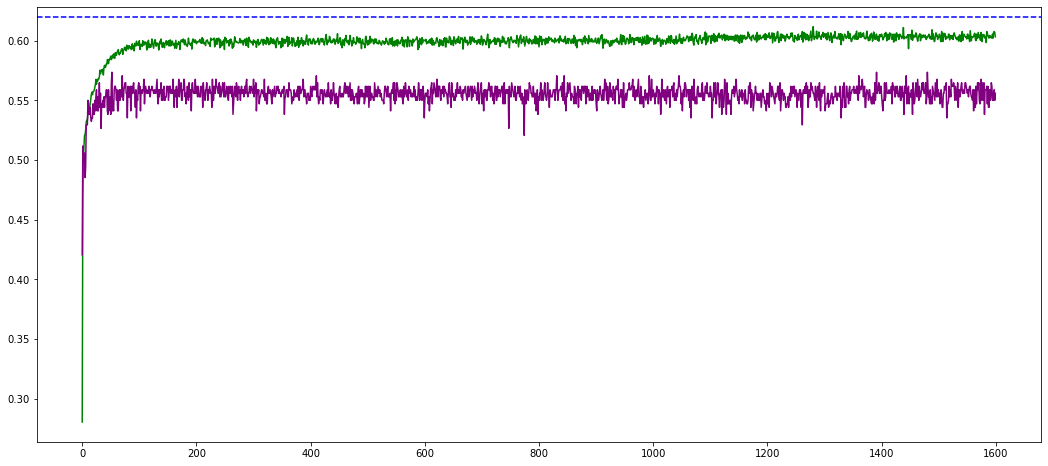

In [7]:
import matplotlib.pyplot as plt

print(history.history.keys())

classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)


fig, ax = plt.subplots(figsize=(18,8))

ax.plot(history.history["accuracy"], color="green")
ax.plot(history.history["val_accuracy"], color="purple")
ax.axhline(constantGuess, color="blue", linestyle="dashed")